In [1]:
#pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('MaunaLoaDailyTemps.csv',
                 index_col='DATE',
                 parse_dates=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2014-01-01 to 2018-12-30
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   MinTemp  1821 non-null   float64
 1   MaxTemp  1821 non-null   float64
 2   AvgTemp  1821 non-null   float64
 3   Sunrise  1825 non-null   int64  
 4   Sunset   1825 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 85.5 KB


In [5]:
df.isnull().sum()

MinTemp    4
MaxTemp    4
AvgTemp    4
Sunrise    0
Sunset     0
dtype: int64

In [6]:
df.dropna(inplace=True,how='any')

In [7]:
df.shape

(1821, 5)

In [8]:
df.sample(4)

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2017-04-23,39.0,55.0,47.0,559,1843
2018-11-14,38.0,56.0,47.0,630,1743
2015-04-09,34.0,51.0,43.0,610,1839
2016-11-01,42.0,55.0,49.0,624,1748


<Axes: xlabel='DATE'>

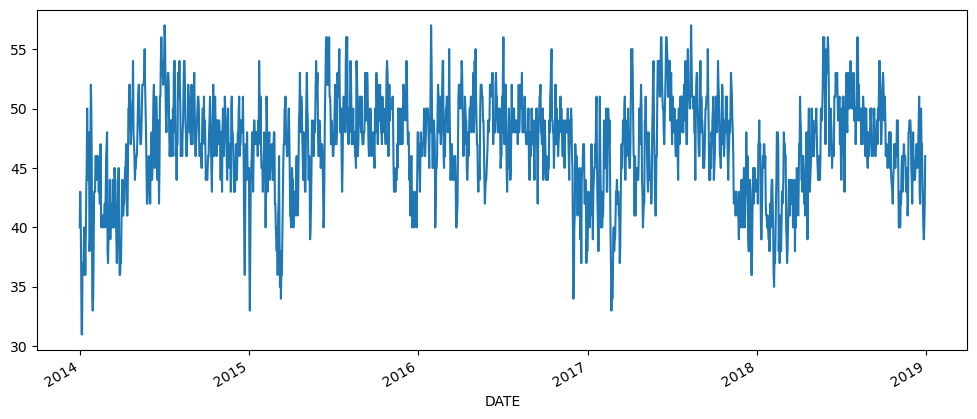

In [9]:
#We will see how Avg Temp. changes with respect to time
df['AvgTemp'].plot(figsize=(12,5))

In [10]:
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
        
    if dftest[0] < dftest[4]["5%"] and dftest[1] <= 0.05:
        print(f" Reject NULL Hypothesis - Time Series is Stationary")
    else:
        print("Failed to Reject NULL Hypothesis - Time Series is Non-Stationary")

In [11]:
adf_test(df['AvgTemp'])

1. ADF :  -6.554680125068782
2. P-Value :  8.675937480199415e-09
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1808
5. Critical Values :
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872
 Reject NULL Hypothesis - Time Series is Stationary


#### PMDARIMA takes cares of all the orders of AR,MA and Diff


In [12]:
"""
1. trace=true : it would print all the steps as it iterates
2. Auto_Arima will try different combinations of orders like
(0,1,0) , (0,2,1) ... and for every order(every model), it 
will assign a score called AIC. The goal is to minimize the 
AIC.

In auto ARIMA, the Akaike Information Criterion (AIC) is a measure 
of the quality of fit of a statistical model. It is used to compare 
different models and select the best one based on the AIC score.
"""
stepwise_fit = auto_arima(df['AvgTemp'], trace=True,
                         suppress_warnings=True
                         )

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8344.224, Time=1.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10347.755, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8365.701, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9136.225, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19192.139, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8355.947, Time=1.39 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8356.308, Time=1.32 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8347.288, Time=1.82 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=8317.782, Time=1.76 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=8330.194, Time=1.67 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=8309.798, Time=2.23 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=8332.407, Time=2.24 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=8317.598, Time=2.65 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=8305.137, Time=2.39 sec
 ARIMA(1,0,4)(0,0,0)[0] interce

In [13]:
print(stepwise_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1821
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -4139.685
Date:                Fri, 28 Apr 2023   AIC                           8295.370
Time:                        17:29:23   BIC                           8339.427
Sample:                             0   HQIC                          8311.623
                               - 1821                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2504      0.375      3.338      0.001       0.516       1.985
ar.L1          0.9730      0.008    120.307      0.000       0.957       0.989
ma.L1         -0.1230      0.024     -5.143      0.0

In [14]:
#now we will fit the best order done by auto_arima into ARIMA
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(1821, 5)
(1791, 5) (30, 5)
MinTemp      36.0
MaxTemp      52.0
AvgTemp      44.0
Sunrise     640.0
Sunset     1743.0
Name: 2018-12-01 00:00:00, dtype: float64 MinTemp      39.0
MaxTemp      52.0
AvgTemp      46.0
Sunrise     656.0
Sunset     1754.0
Name: 2018-12-30 00:00:00, dtype: float64


#### Train the Model

In [15]:
model=ARIMA(train['AvgTemp'],order=(1,0,5))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                AvgTemp   No. Observations:                 1791
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -4070.198
Date:                Fri, 28 Apr 2023   AIC                           8156.395
Time:                        17:29:24   BIC                           8200.320
Sample:                             0   HQIC                          8172.614
                               - 1791                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.5856      0.758     61.454      0.000      45.100      48.071
ar.L1          0.9856      0.005    188.230      0.000       0.975       0.996
ma.L1         -0.1412      0.023     -6.124      0.000      -0.186      -0.096
ma.L2         -0.2268      0.024     -9.635      0.000      -0.273      -0.181
ma.L3         -0.2168      0.023     -9.251      0.000      -0.263      -0.171
ma.L4         -0.1479      0.023     -6.491      0.000      -0.193      -0.103
ma.L5         -0.0595      0.024     -2.438      0.015      -0.107      -0.012
sigma2         5.5093      0.174     31.624      0.000       5.168       5.851
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.88
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<b>Make Predictions on Test Set</b>

In [16]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')

"""
Running just above code gave this below output
1791    44.754109
1792    44.987795
1793    45.388741

But we need dates instead of 1791,1792..
so use this below line as we need dates to show plot
"""
pred.index = df.index[start:end+1]


In [17]:
pred

DATE
2018-12-01    44.754109
2018-12-02    44.987795
2018-12-03    45.388741
2018-12-04    45.721545
2018-12-05    45.863733
2018-12-06    45.874126
2018-12-07    45.884370
2018-12-08    45.894466
2018-12-09    45.904417
2018-12-10    45.914225
2018-12-11    45.923891
2018-12-12    45.933418
2018-12-13    45.942808
2018-12-14    45.952063
2018-12-15    45.961185
2018-12-16    45.970175
2018-12-17    45.979036
2018-12-18    45.987769
2018-12-19    45.996377
2018-12-20    46.004860
2018-12-21    46.013222
2018-12-22    46.021463
2018-12-23    46.029585
2018-12-24    46.037591
2018-12-25    46.045481
2018-12-26    46.053258
2018-12-27    46.060922
2018-12-28    46.068477
2018-12-29    46.075922
2018-12-30    46.083261
Name: ARIMA predictions, dtype: float64

<Axes: xlabel='DATE'>

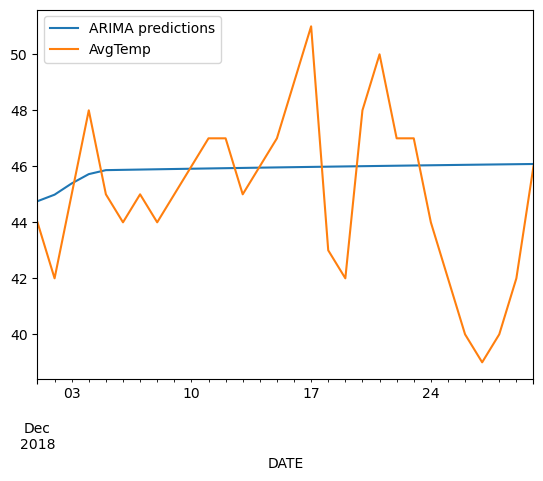

In [18]:
pred.plot(legend=True)
test['AvgTemp'].plot(legend=True)

In [19]:
test['AvgTemp'].mean()

45.0

#### Mean Squared Error

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred,test['AvgTemp']))
rmse

3.0004637990836747

In [21]:
#So RMSE is good as it is small compared to mean

In [22]:
#Now we will fit the model on whole data and predict future dates
model2=ARIMA(df['AvgTemp'],order=(1,0,5))
model2=model2.fit()
df.tail()

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2018-12-26,35.0,45.0,40.0,654,1752
2018-12-27,33.0,44.0,39.0,655,1752
2018-12-28,33.0,47.0,40.0,655,1753
2018-12-29,36.0,47.0,42.0,655,1753
2018-12-30,39.0,52.0,46.0,656,1754


### For Future Dates

In [23]:
index_future_dates=pd.date_range(start='2018-12-30',end='2019-01-29')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2018-12-30    46.418166
2018-12-31    46.113912
2019-01-01    45.617874
2019-01-02    45.249566
2019-01-03    45.116916
2019-01-04    45.136667
2019-01-05    45.156141
2019-01-06    45.175342
2019-01-07    45.194275
2019-01-08    45.212944
2019-01-09    45.231350
2019-01-10    45.249500
2019-01-11    45.267395
2019-01-12    45.285040
2019-01-13    45.302438
2019-01-14    45.319593
2019-01-15    45.336507
2019-01-16    45.353185
2019-01-17    45.369630
2019-01-18    45.385844
2019-01-19    45.401832
2019-01-20    45.417596
2019-01-21    45.433139
2019-01-22    45.448465
2019-01-23    45.463577
2019-01-24    45.478477
2019-01-25    45.493168
2019-01-26    45.507654
2019-01-27    45.521937
2019-01-28    45.536021
2019-01-29    45.549907
Freq: D, Name: ARIMA Predictions, dtype: float64


<Axes: >

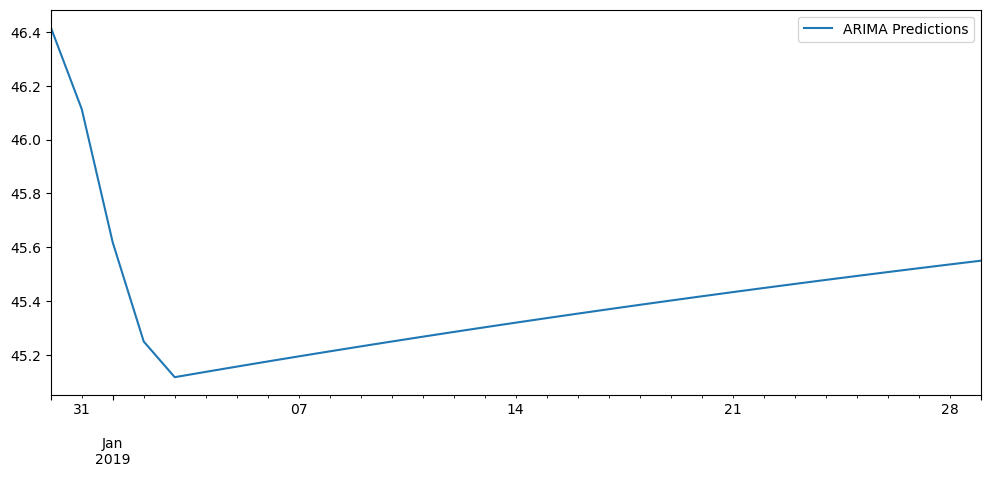

In [24]:
pred.plot(figsize=(12,5),legend=True)